In [214]:
import dask.dataframe as ddf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [20]:
energy = ddf.read_csv("dems/300/energy_chunked.csv/*").repartition(npartitions=1)
energy.to_parquet("dems/300/energy.parquet")
# energy.repartition(npartitions=90).to_csv("dems/300/energy_chunked.csv")
# energy.loc[energy["iter"]%100 == 0].repartition(npartitions=1).to_csv("dems/300/energy_100.csv")

In [36]:
np.arange(known.shape[0], 0, -1) - 1

array([8, 7, 6, 5, 4, 3, 2, 1, 0])

In [123]:
8//3

2

In [134]:
31//5 + 1

7

In [128]:
np.arange(35).reshape(7, 5)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34]])

In [150]:
11//5, 11 % 5

(2, 1)

9

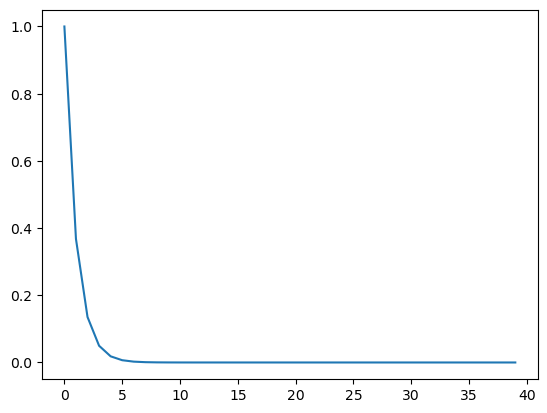

In [330]:

from time import perf_counter as timer

In [342]:
rng = np.random.default_rng(0)
cell_area = 1.0
gamma = 0.5
nrow, ncol = 15, 15
n_iter = nrow*ncol*20

T = np.exp(-10*np.linspace(0, 1, n_iter))

outlets = [nrow*ncol-1]

W = np.zeros((nrow*ncol, nrow*ncol), dtype=int)
for i in range(nrow*ncol):
    for j in range(nrow*ncol):
        if (
            i//ncol == j//ncol 
            and i != j 
            and j == i + 1
        ):
            W[i, j] = 1
        if (
            (i + 1)%ncol == 0
            and j == i + ncol
        ):
            W[i, j] = 1

nodes = np.arange(W.shape[0])
alpha = cell_area*np.ones((W.shape[0], 1))

def compute_A(W, alpha):
    return np.linalg.inv(np.eye(W.shape[0]) - W.T)@alpha
def compute_H(A, gamma):
    return (A**gamma).sum()

def get_neighbs_of_i(i, nrow, ncol):
    # UL corner
    if i == 0:
        neighbors = np.array([                 i + 1, 
                            i + ncol, i + ncol + 1])
    # UR corner
    elif i == ncol - 1:
        neighbors = np.array([i - 1, 
                            i + ncol - 1, i + ncol])
    # LL corner
    elif i == ncol*nrow - ncol:
        neighbors = np.array([i - ncol, i - ncol + 1, 
                                            i + 1])
    # LR corner
    elif i == nrow*ncol - 1:
        neighbors = np.array([i - ncol - 1, i - ncol, 
                            i - 1])
    # left edge
    elif i%ncol == 0:
        neighbors = np.array([i - ncol, i - ncol + 1, 
                                            i + 1, 
                            i + ncol, i + ncol + 1])
    # right edge
    elif (i + 1)%ncol == 0:
        neighbors = np.array([i - ncol - 1, i - ncol, 
                            i - 1, 
                            i + ncol - 1, i + ncol])
    # top edge
    elif i//ncol == 0:
        neighbors = np.array([i - 1,                         i + 1, 
                            i + ncol - 1, i + ncol, i + ncol + 1])
    # bottom edge
    elif i//ncol + 1 == ncol:
        neighbors = np.array([i - ncol - 1, i - ncol, i - ncol + 1, 
                            i - 1,                         i + 1])
    # center
    else:
        neighbors = np.array([i - ncol - 1, i - ncol, i - ncol + 1, 
                            i - 1,                         i + 1, 
                            i + ncol - 1, i + ncol, i + ncol + 1])
    return neighbors
neighbors = [get_neighbs_of_i(i, nrow, ncol) for i in nodes]

def is_invertible(M):
    return (np.linalg.matrix_rank(M) == M.shape[0]) and (M.shape[0] == M.shape[1])

def rewire_node(W, node_to_rewire, candidate_path):
    W[node_to_rewire, :] = 0
    W[node_to_rewire, candidate_path] = 1
    return

energy = np.full(n_iter, np.nan)
for i in tqdm(range(n_iter)):
    valid_rewirings = np.zeros_like(W)
    while True:  # Metro Hastings loop
        while True:  # invertibility loop
            W_new = W.copy()
            node_to_rewire = rng.choice(np.setdiff1d(nodes, outlets))
            candidate_path = rng.choice(neighbors[node_to_rewire])
            rewire_node(W_new, node_to_rewire, candidate_path)
            
            if valid_rewirings[node_to_rewire, candidate_path]:
                break

            elif is_invertible(np.eye(W_new.shape[0]) - W_new.T): 
                valid_rewirings[node_to_rewire, candidate_path] = 1
                break

        # compute new energy
        A = compute_A(W, alpha)
        H = compute_H(A, gamma)

        A_new = compute_A(W_new, alpha)
        H_new = compute_H(A_new, gamma)
        if H_new < H:
            break
        elif np.exp(-(H_new - H)/T[i]) > rng.uniform(0, 1):
            break

    energy[i] = H_new
    A = A_new
    W = W_new.copy()
        


  0%|          | 0/4500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [336]:
processing_times

{'invert': 13.65084979380481, 'compute': 0.5092748335446231}

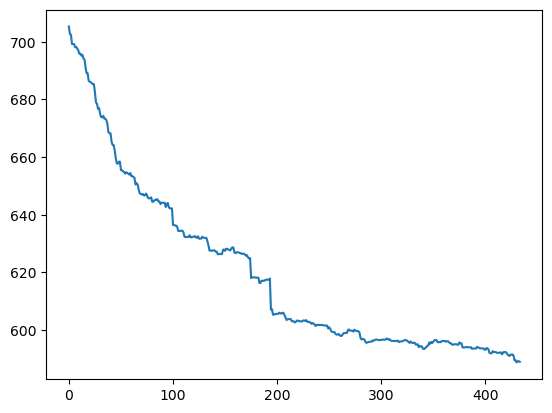

In [343]:
plt.plot(energy)

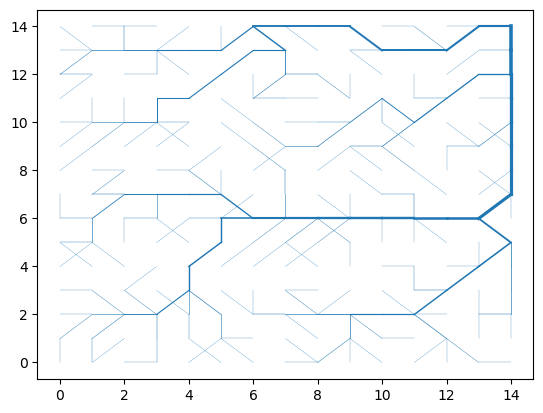

In [344]:

def draw_W(W, ncol, A):
    x, y, u, v, width = [], [], [], [], []
    for i in range(W.shape[0]):
        irow, icol = i//ncol, i%ncol
        for j in range(W.shape[1]):
            jrow, jcol = j//ncol, j%ncol
            if W[i, j]:
                x.append(icol)
                y.append(irow)
                u.append(jcol - icol)
                v.append(jrow - irow)
                width.append(A[i, 0])
                plt.plot([icol, jcol], [irow, jrow], lw=np.sqrt(A[i, 0]/A.max())*3, color="C0")
draw_W(W, ncol, A)

In [ ]:
: